# Analyze Zacros kMC trajectories data for O-Pt(111)

In [1]:
import numpy as np
from pathlib  import Path
import json
import matplotlib.pyplot as plt
import zacros_functions as zf

In [2]:
# Time binning parameters
n_bins = 100

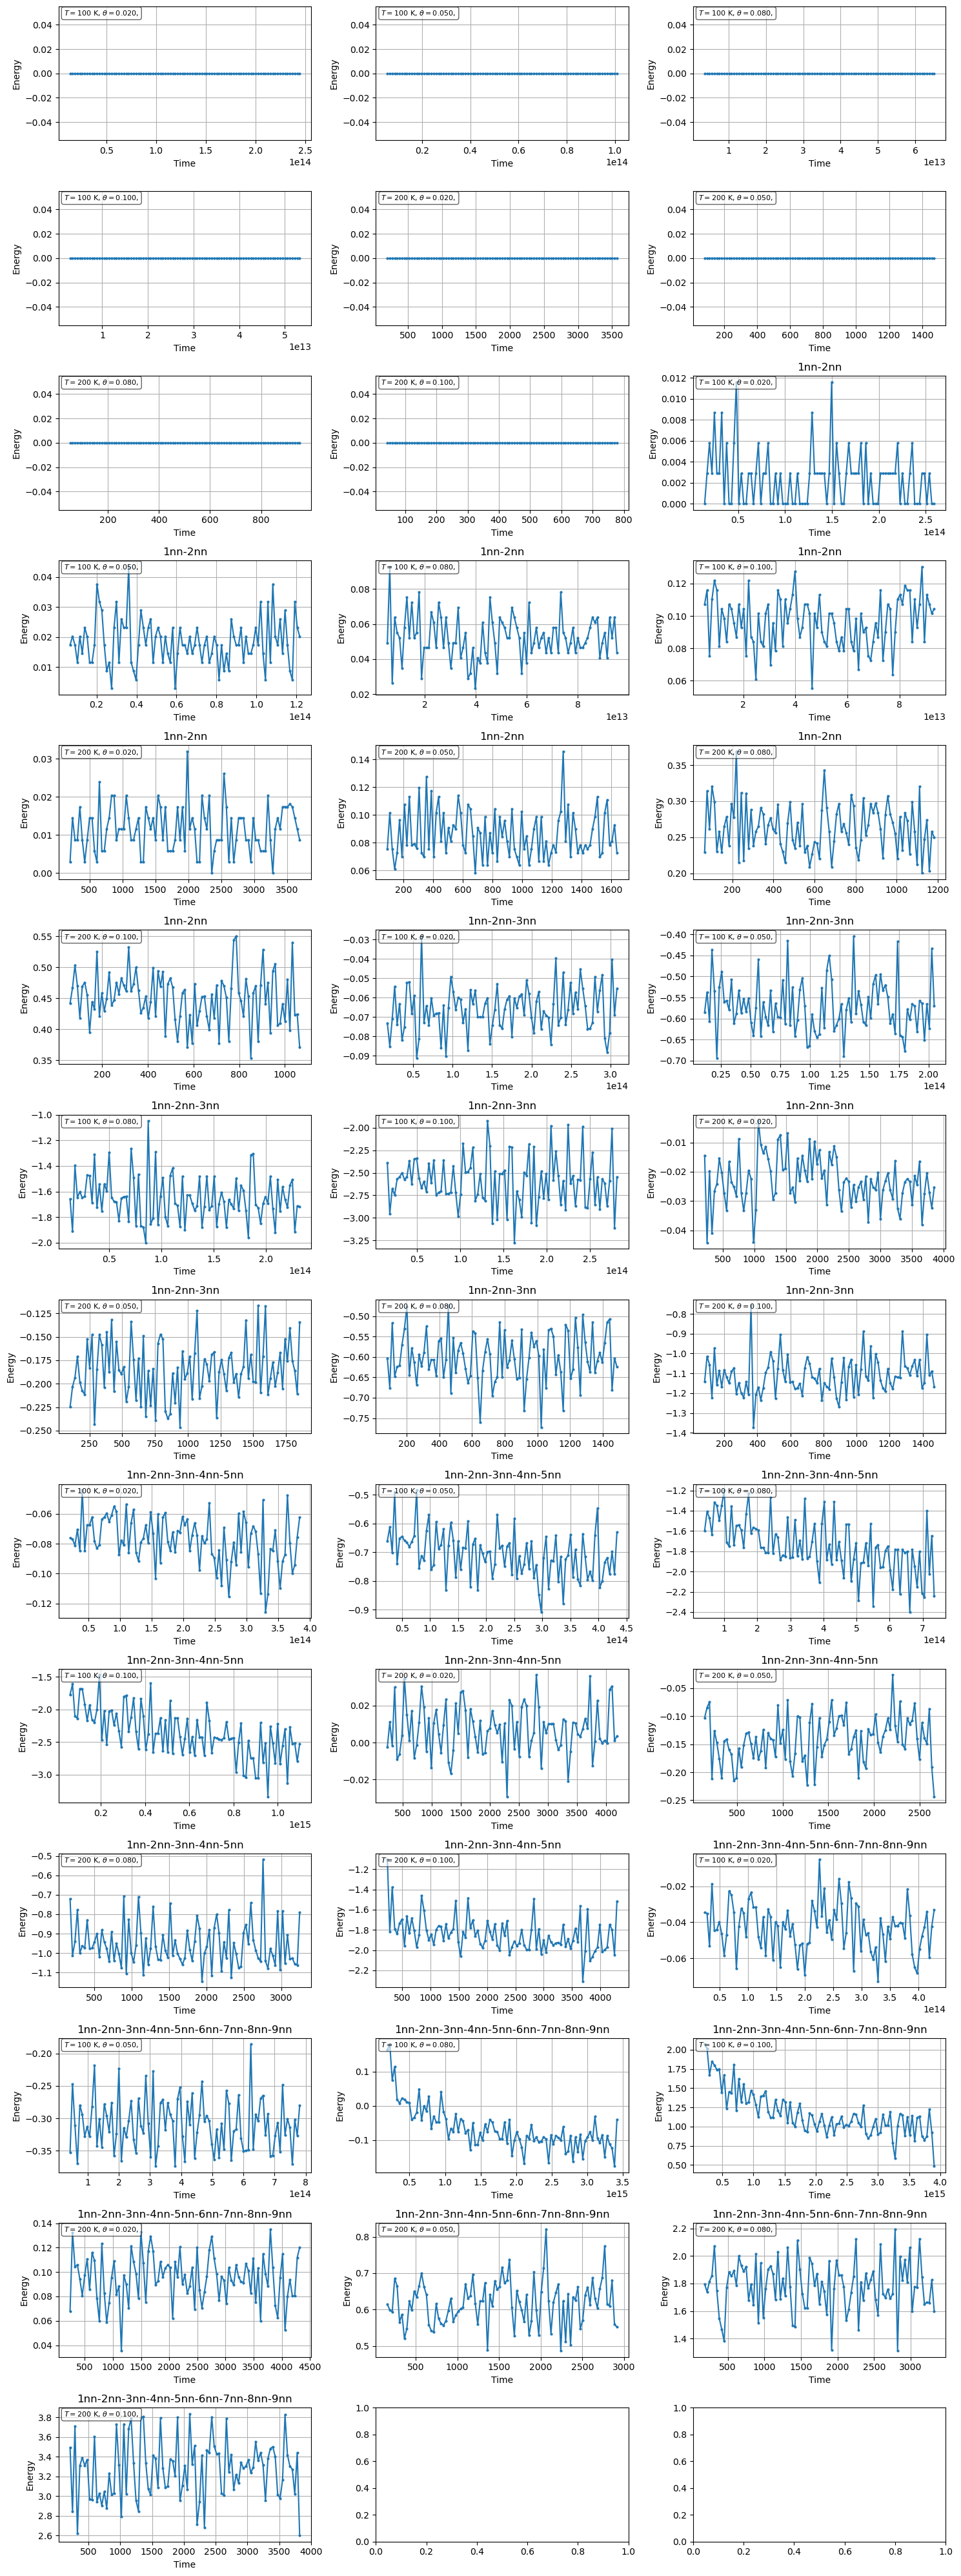

In [3]:
# Set directories and file names
# and get the starting point for equilibrium
# from the averaged energy plots

log_dir = Path.cwd() / 'zacros_calculations'
data_dir = log_dir / 'jobs'
results_dir = log_dir / 'results'
log_file = log_dir / 'jobs.log'
en_file_suffix  = 'energy.dat'
rdf_file_suffix = 'rdf.dat'
csd_file_suffix = 'csd.dat'
ccd_file_suffix = 'ccd.dat'

# Verify the file exists
if not log_file.exists():
    raise FileNotFoundError(f"Log file not found: {log_file}")

# Load json log file
with open(log_file, 'r') as f:
   log_header = f.readline().split()  # Read header
   log_entries = [json.loads(line) for line in f if line.strip()]

Path.mkdir(results_dir, exist_ok=True)
# Analyze data
run_dirs =[data_dir / str(entry[0]) for entry in log_entries]
temperatures = [entry[4] for entry in log_entries]
lat_size = [entry[2][0]*entry[2][1] for entry in log_entries]
n_ads = [entry[3][0] for entry in log_entries]
interactions = ['-'.join(entry[5][1:]) for entry in log_entries]
coverages = [n_ads[i]/lat_size[i] for i in range(len(n_ads))]

ncols = 3
fig, axes = plt.subplots(int(np.ceil(len(run_dirs)/ncols)), ncols, figsize=(15,40))

for ir,rundir in enumerate(run_dirs):

   # Check if the run was analyzed
   if (results_dir / f'{rundir.name}_{en_file_suffix}').exists():
      # print(f' Using the processed data from {results_dir} for {rundir.name}')
      time_bin_centers, energy_hist = np.loadtxt(
                           results_dir / f'{rundir.name}_{en_file_suffix}', unpack=True)

   else:
      # print(f' Processing trajectories from {rundir.name}...')
      # Get list of trajectories
      traj_files = list(rundir.rglob('history_output.txt'))

      # Get number of configurations and maximum kmc time for all trajectories
      nconfs = []
      end_time = np.inf
      for traj_file in traj_files:
         with open(traj_file) as f:
            for line in f: 
               if 'configuration' in line: 
                  confs = int(line.split()[1])
                  conf_time = float(line.split()[3])
         end_time = min(end_time, conf_time)
         nconfs.append(confs)

      time_bins   = np.linspace(0, end_time, n_bins+1)
      energy_hist = np.zeros(n_bins)
      for traj_file, confs in zip(traj_files,nconfs):

         time   = np.zeros(confs)
         energy = np.zeros(confs)

         # Get lattice-site coordinates
         try:
            lattice = np.loadtxt(traj_file.parent / 'lattice_output.txt', usecols=(1,2),skiprows=2)
            nsites  = len(lattice)
         except Exception:
            raise FileNotFoundError('lattice_output.txt not found in ' + str(traj_file.parent))
         
         # Get adsorbate positions
         counter = 0
         with open(traj_file) as f:
            for line in f:
                  if 'configuration' in line:
                     time[counter]   = float(line.split()[3])
                     energy[counter] = float(line.split()[5])
                     counter += 1

         # Create average energy histogram with n_bins
         for i in range(confs):
            bin_index = np.digitize(time[i], time_bins,right=False) - 1
            if bin_index < confs: energy_hist[bin_index] += energy[i]

      energy_hist /= len(nconfs)
      # Save processed data
      time_bin_centers = 0.5 * (time_bins[:-1] + time_bins[1:])
      np.savetxt(results_dir / f'{rundir.name}_{en_file_suffix}', 
                 np.column_stack((time_bin_centers, energy_hist)), 
                 header='Time_s Energy_eV')

   # Plot energy as function of time using subplots
   ax = axes[ir//ncols, ir%ncols]
   ax.plot(time_bin_centers[5:], energy_hist[5:], marker='o', linestyle='-', markersize=2)
   ax.set_xlabel('Time')
   ax.set_ylabel('Energy')
   ax.set_title(f'{interactions[ir]}')
   ax.text(0.02, 0.98, fr'$T={temperatures[ir]}$ K, $\theta={coverages[ir]:.3f}$, ',
             transform=ax.transAxes,
             va='top', ha='left',
             fontsize=8,
             bbox=dict(boxstyle='round', facecolor='white', alpha=0.6))

   ax.grid()

plt.tight_layout()
plt.show()

Radial Distribution Functions

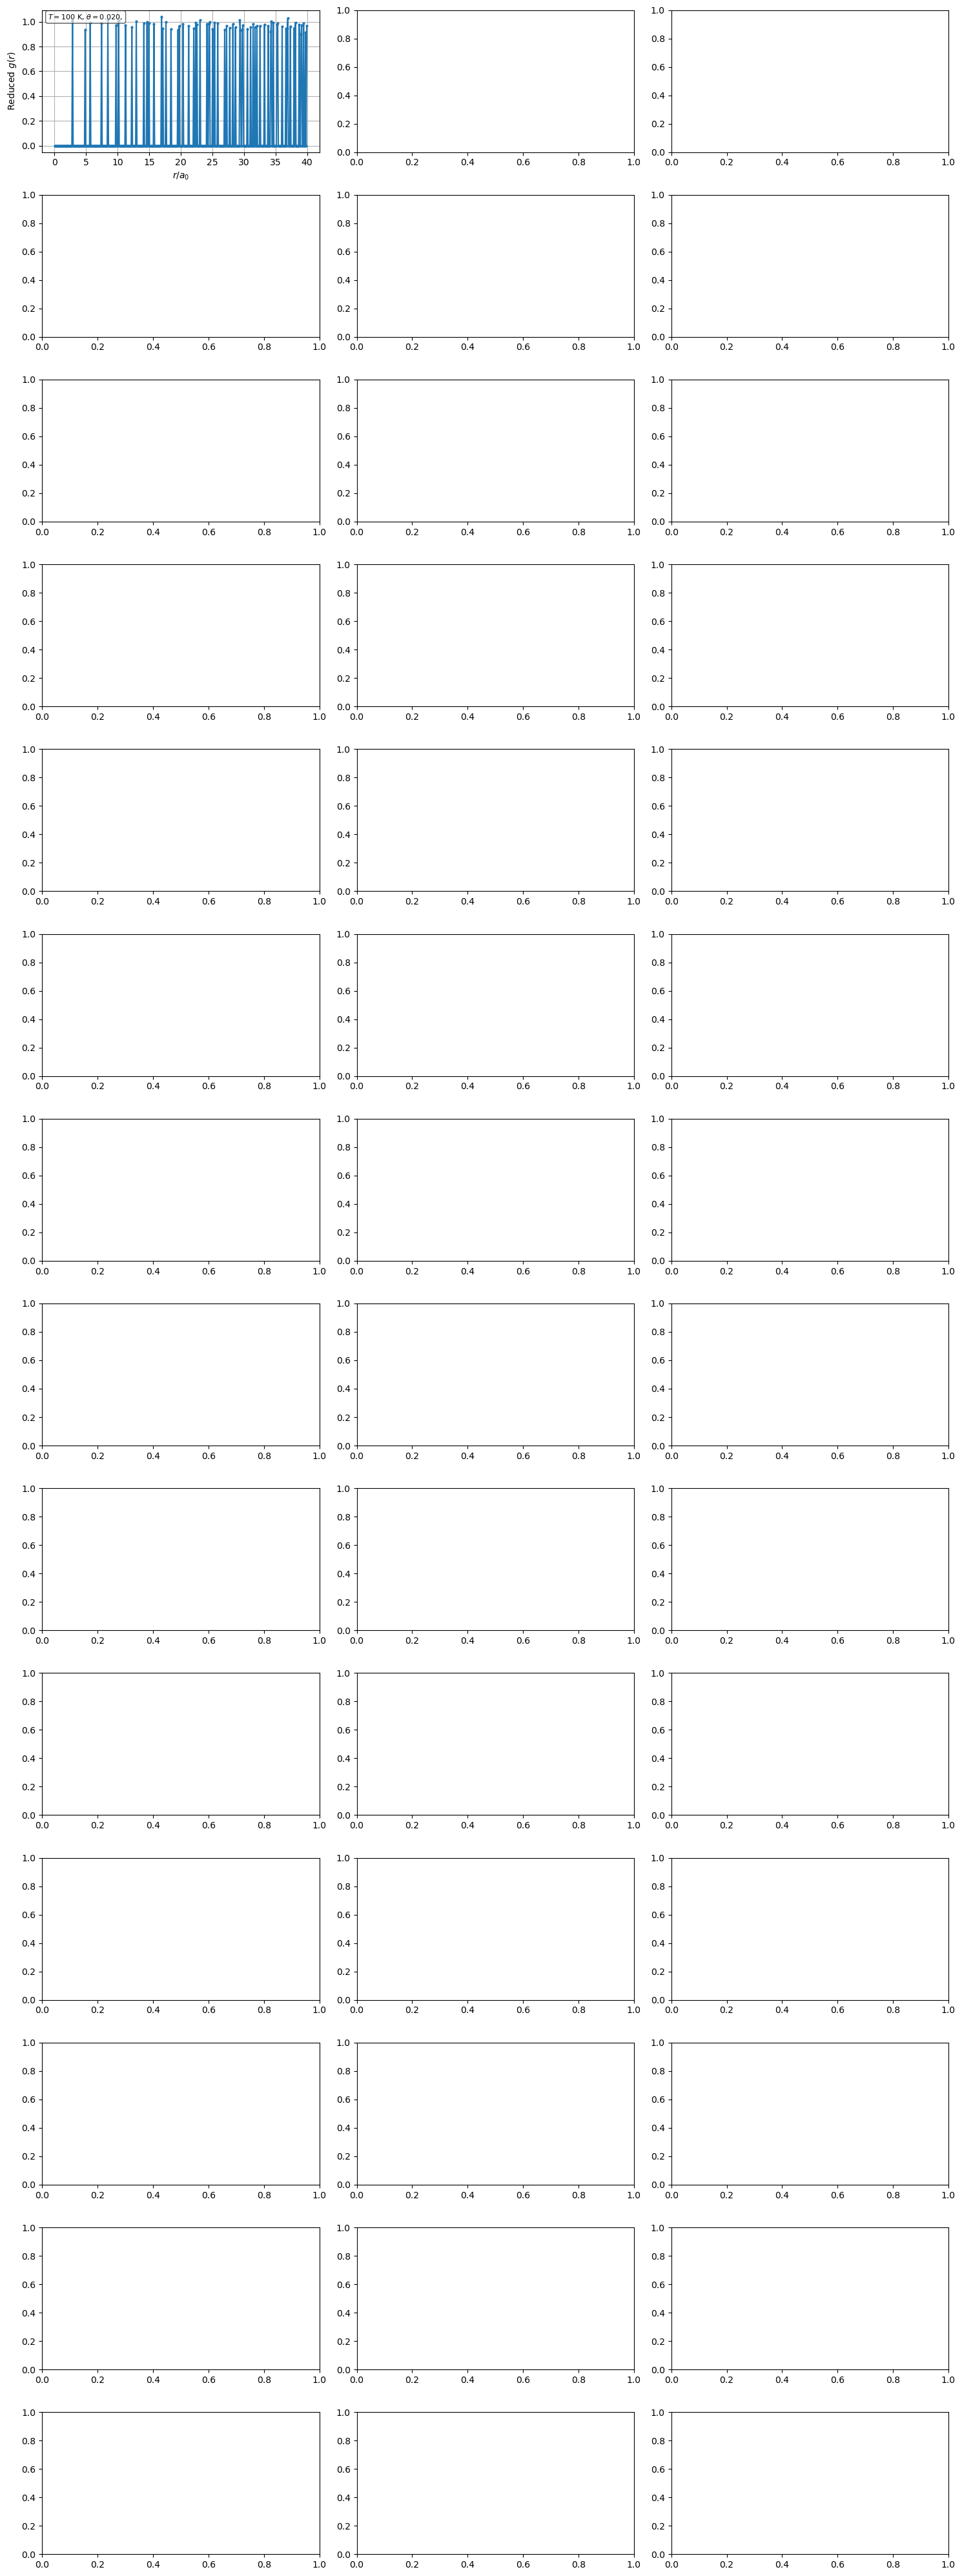

In [6]:
# Set the starting point for equilibrium from the averaged energy plots
fraction_eq = 0.5
# Consider extracting the lattice constant from zacros input files
lattice_constant = 2.821135
# RDF parameters
r_max = 40.0
dr    = 0.1
nbins = int(np.ceil(r_max / dr))
g_avg = np.zeros(nbins)

ncols = 3
fig_rdf, axes_rdf = plt.subplots(int(np.ceil(len(run_dirs)/ncols)), ncols, figsize=(15,40))

start_ir = 0
for irr,rundir in enumerate(run_dirs[start_ir:1]):
   ir = irr + start_ir

   # Check if the run was analyzed
   if (results_dir / f'{rundir.name}_{rdf_file_suffix}').exists():
      # print(f' Using the processed data from {results_dir} for {rundir.name}')
      r, g_avg = np.loadtxt(results_dir / f'{rundir.name}_{rdf_file_suffix}', unpack=True)

   else:

      # print(f' Processing trajectories from {rundir.name}...')
      # Get list of trajectories
      traj_files = list(rundir.rglob('history_output.txt'))

      # Get number of configurations
      nconfs = []
      for traj_file in traj_files:
         with open(traj_file) as f:
            for line in f: 
               if 'configuration' in line: 
                  confs = int(line.split()[1])
         nconfs.append(confs)

      for traj_file, confs in zip(traj_files,nconfs):

         # Get lattice-site coordinates
         try:
            lattice = np.loadtxt(traj_file.parent / 'lattice_output.txt', usecols=(1,2),skiprows=2)
            with open(traj_file.parent / 'lattice_output.txt') as f:
               v1 = np.array(f.readline().split()[1:3], dtype=float)
               v2 = np.array(f.readline().split()[1:3], dtype=float)
            nsites  = len(lattice)
         except Exception:
            raise FileNotFoundError('lattice_output.txt not found in ' + str(traj_file.parent))
         
         # Get reference RDF for full coverage
         r, g_ref = zf.rdf([lattice], 1, v1, v2, 
                        lattice_constant=lattice_constant, r_max=r_max, dr=dr,
                        plot=False)

         # Get adsorbate positions
         ads_coords = zf.get_xy(traj_file.parent / 'lattice_input.dat')        

         # Get RDF averaged over configurations in trajectory
         r, g_traj = zf.rdf(ads_coords[:-int(fraction_eq*len(ads_coords))], 
                        coverages[ir], v1, v2, 
                        lattice_constant=lattice_constant, r_max=r_max, dr=dr,
                        g_ref=g_ref, plot=False)
         g_avg += g_traj / len(traj_files)

      # Save processed data
      np.savetxt(results_dir / f'{rundir.name}_{rdf_file_suffix}', 
                 np.column_stack((r, g_avg)), 
                 header='r_Angstroem rdf_au')

   # Plot rdf using subplots
   ax = axes_rdf[ir//ncols, ir%ncols]
   ax.plot(r, g_avg, marker='o', linestyle='-', markersize=2)
   ax.set_xlabel(r'$r/a_0$')
   ax.set_ylabel('Reduced $g(r)$')
   ax.set_title(f'{interactions[ir]}')
   ax.text(0.02, 0.98, fr'$T={temperatures[ir]}$ K, $\theta={coverages[ir]:.3f}$, ',
             transform=ax.transAxes,
             va='top', ha='left',
             fontsize=8,
             bbox=dict(boxstyle='round', facecolor='white', alpha=0.6))

   ax.grid()


fig_rdf.tight_layout()
#fig_rdf.show()

Cluster Size and Circularity Distributions

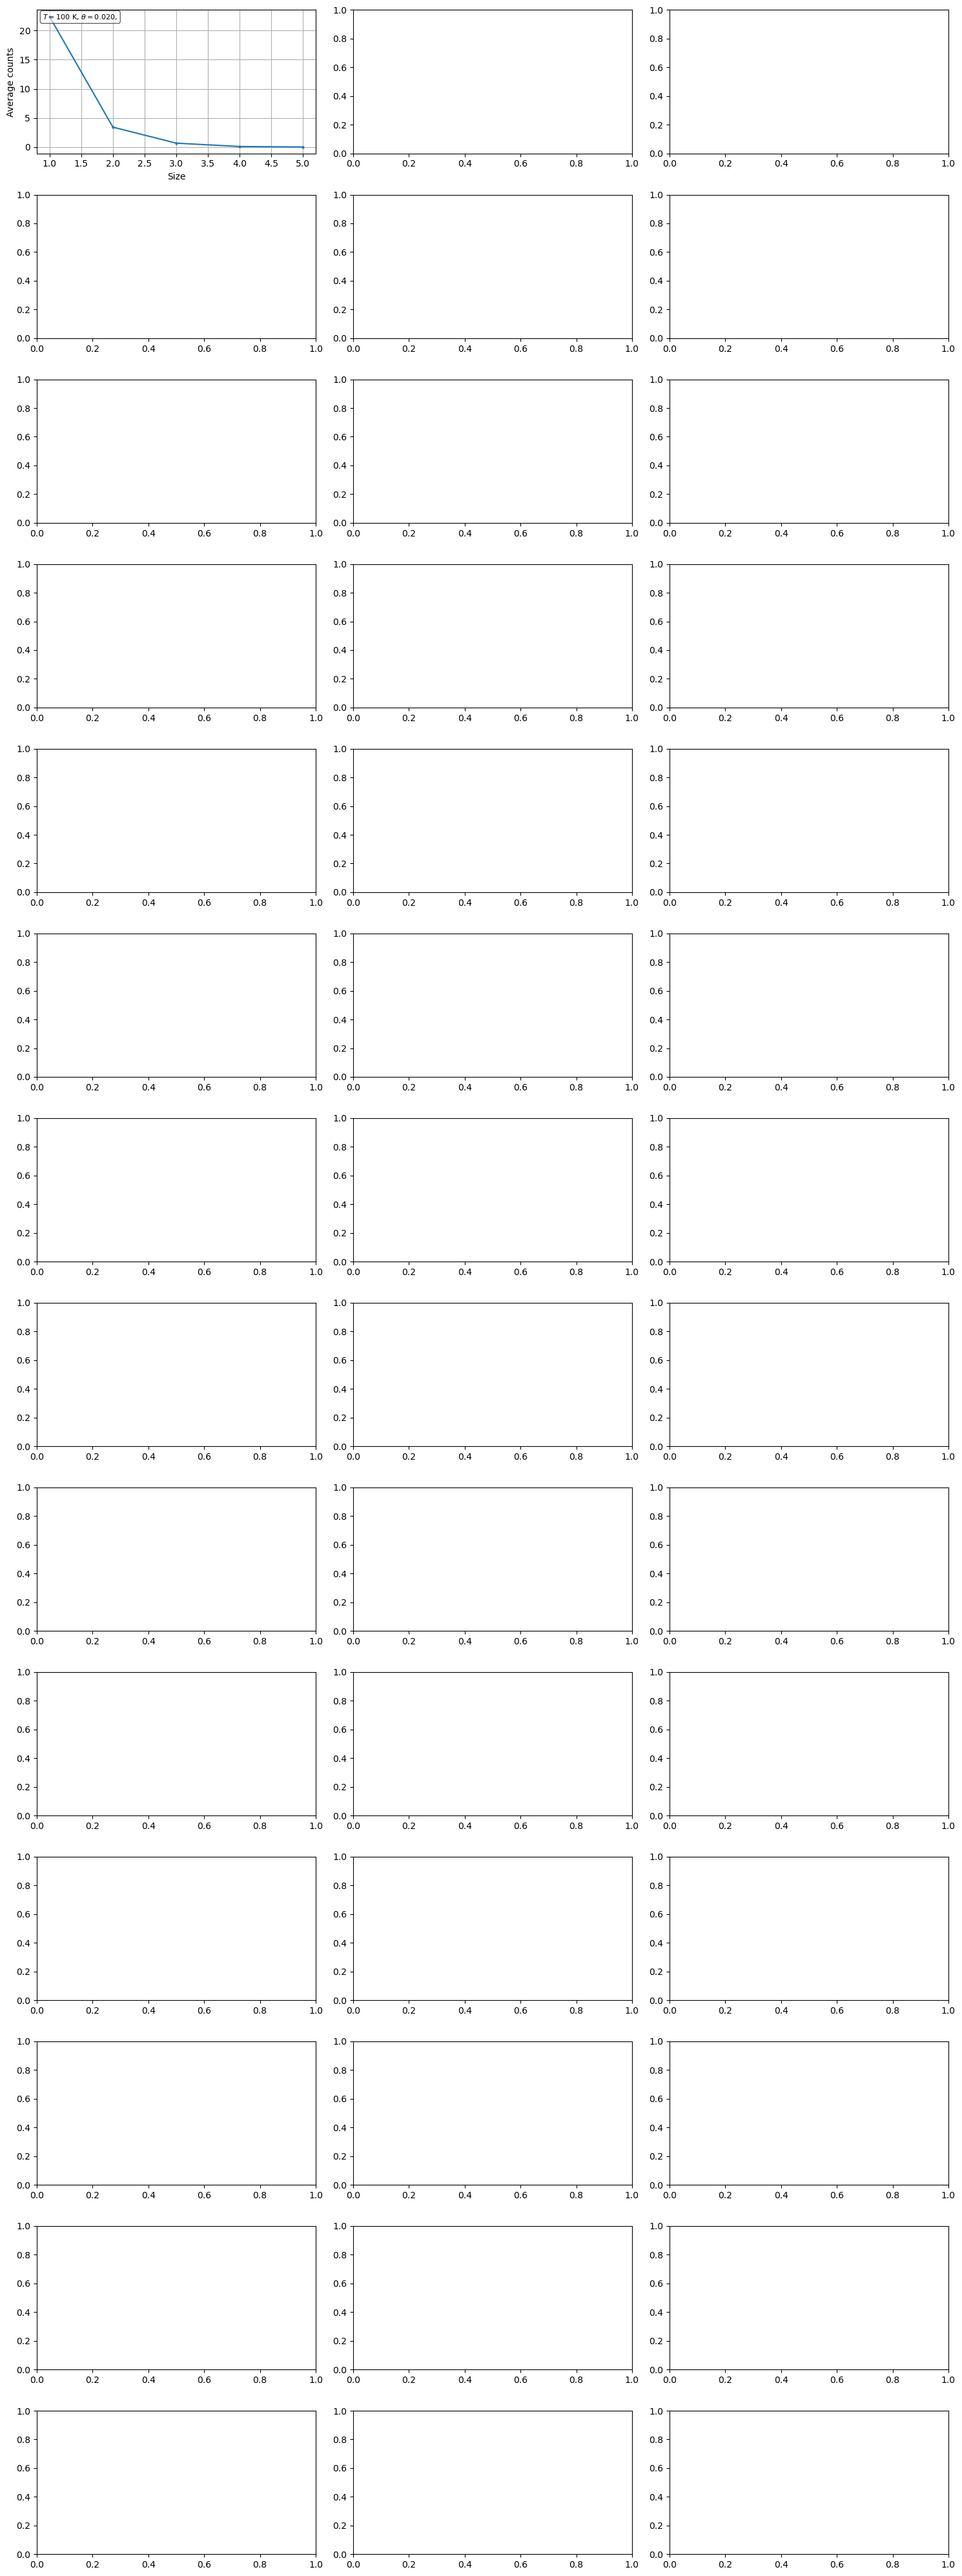

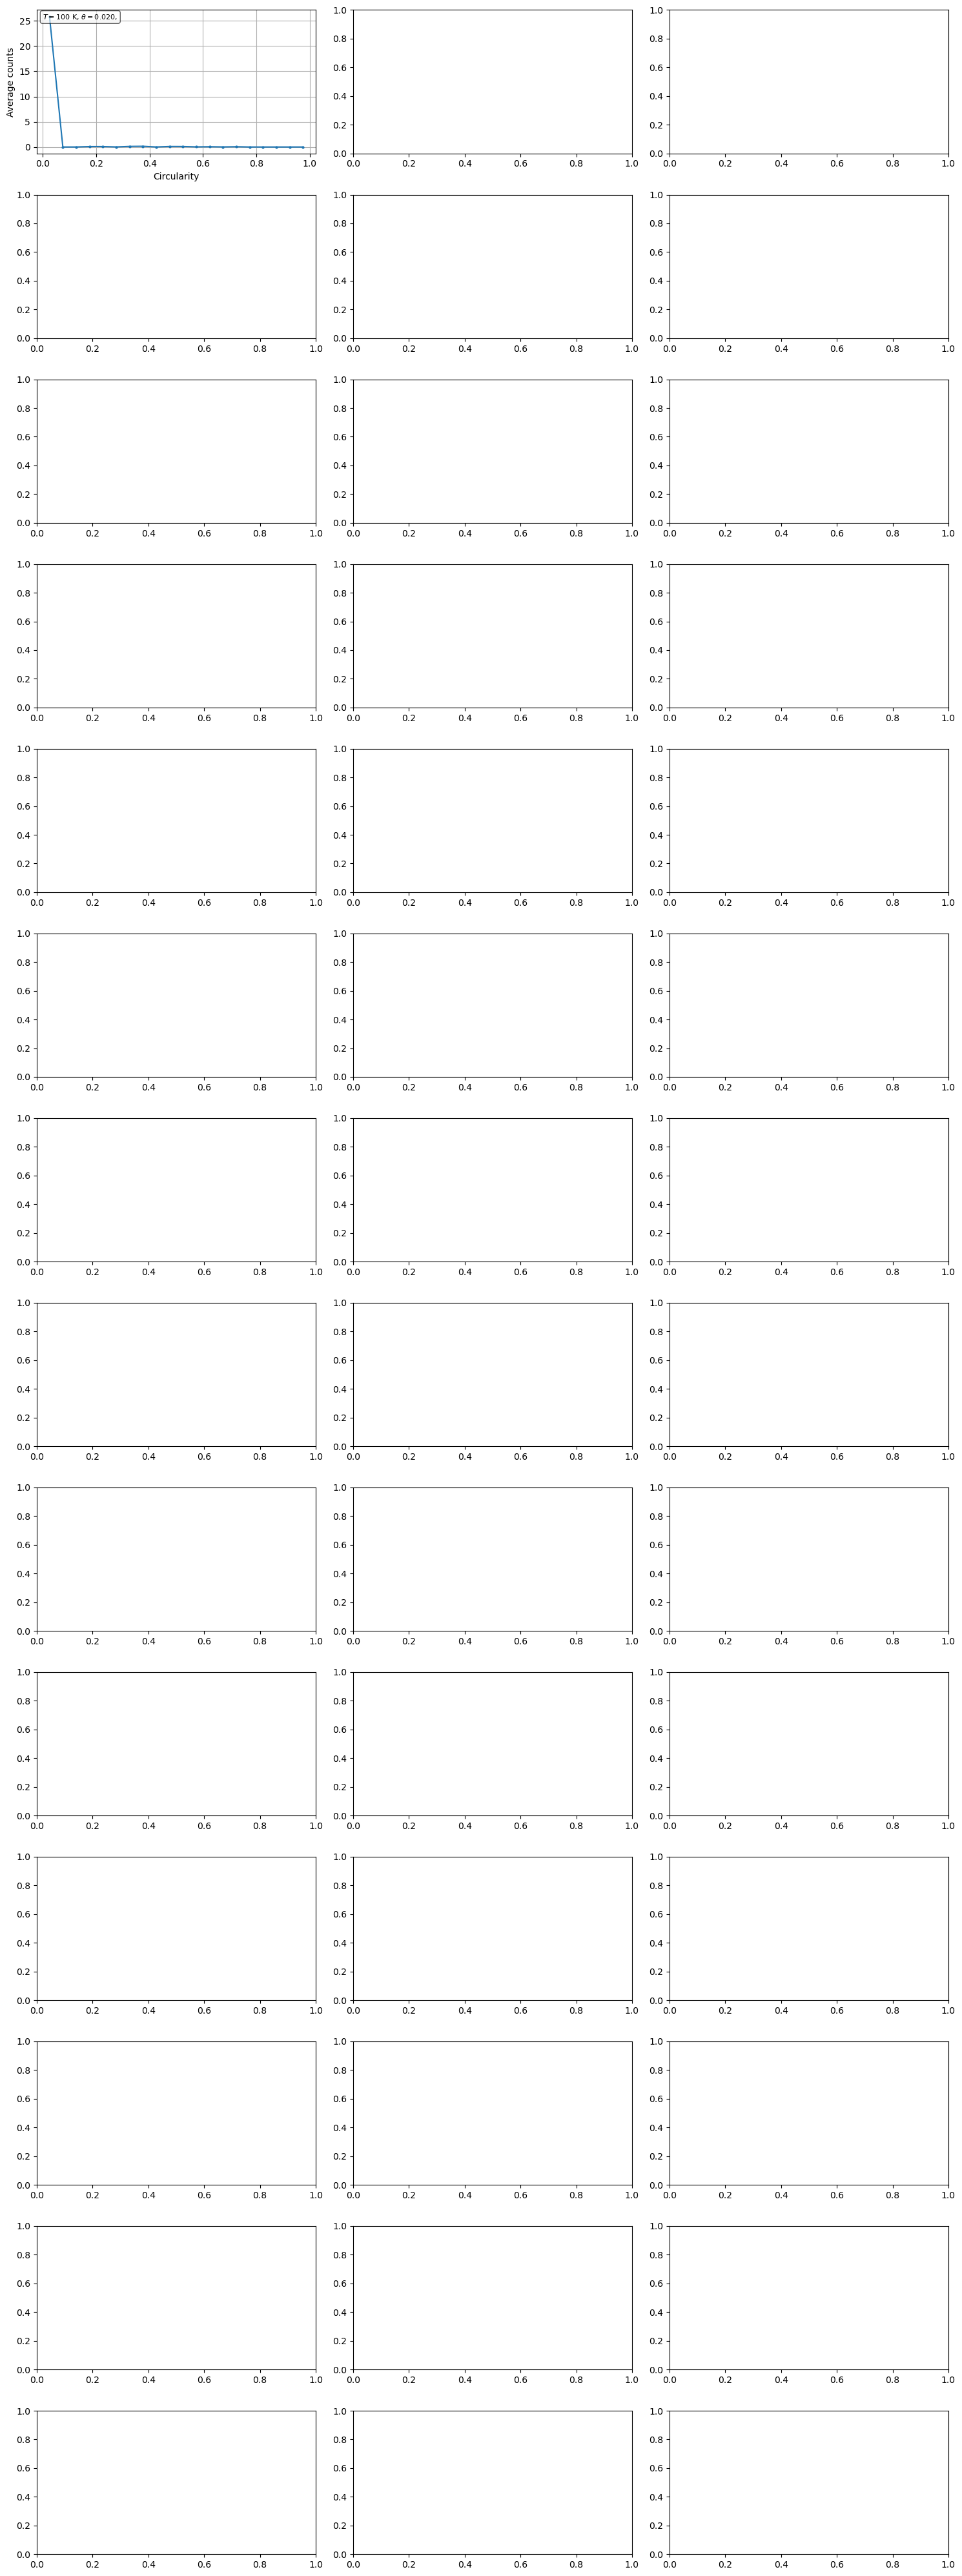

In [9]:
# Set the starting point for equilibrium from the averaged energy plots
fraction_eq = 0.5
# Consider extracting the lattice constant from zacros input files
lattice_constant = 2.821135
# Cluster circularity parameters
nbins_circ = 20

ncols = 3
fig_csd, axes_csd = plt.subplots(int(np.ceil(len(run_dirs)/ncols)), ncols, figsize=(15,40))
fig_ccd, axes_ccd = plt.subplots(int(np.ceil(len(run_dirs)/ncols)), ncols, figsize=(15,40))

start_ir = 0
for irr,rundir in enumerate(run_dirs[start_ir:1]):
   ir = irr + start_ir

   # Check if the run was analyzed
   if (results_dir / f'{rundir.name}_{csd_file_suffix}').exists():
      # print(f' Using the processed data from {results_dir} for {rundir.name}')
      csd_xs1, csd_avg1 = np.loadtxt(results_dir / f'{rundir.name}_{csd_file_suffix}', unpack=True)
      ccd_x, ccd_avg    = np.loadtxt(results_dir / f'{rundir.name}_{ccd_file_suffix}', unpack=True)

   else:

      # print(f' Processing trajectories from {rundir.name}...')
      # Get list of trajectories
      traj_files = list(rundir.rglob('history_output.txt'))

      # Get number of configurations
      nconfs = []
      for traj_file in traj_files:
         with open(traj_file) as f:
            for line in f: 
               if 'configuration' in line: 
                  confs = int(line.split()[1])
         nconfs.append(confs)

      # Get number of lattice sites from the first trajectory
      try:
         lattice = np.loadtxt(traj_files[0].parent / 'lattice_output.txt', usecols=(1,2),skiprows=2)
         nsites  = len(lattice)
      except Exception:
         raise FileNotFoundError('lattice_output.txt not found in ' + str(traj_files[0].parent))
     
      csd_xs  = np.zeros(nsites)
      csd_avg = np.zeros(nsites)
      ccd_avg = np.zeros(nbins_circ)
      for traj_file, confs in zip(traj_files,nconfs):

         # Get lattice-site coordinates
         try:
            lattice = np.loadtxt(traj_file.parent / 'lattice_output.txt', usecols=(1,2),skiprows=2)
            with open(traj_file.parent / 'lattice_output.txt') as f:
               v1 = np.array(f.readline().split()[1:3], dtype=float)
               v2 = np.array(f.readline().split()[1:3], dtype=float)
            nsites  = len(lattice)
         except Exception:
            raise FileNotFoundError('lattice_output.txt not found in ' + str(traj_file.parent))
         
         # Get adsorbate positions
         ads_coords = zf.get_xy(traj_file.parent / 'lattice_input.dat')        

         # Get cluster size distribution
         csd_x, csd_y, ccd_x, ccd_y = zf.cluster_circularity_periodic_avg(
                                       ads_coords[:-int(fraction_eq*len(ads_coords))], 
                                       v1, v2, 2.01*lattice_constant, nbins=nbins_circ)
         
         # Accumulate cluster size distributions accounting for different lengths
         csd_xs[:len(csd_x)] = csd_x
         csd_avg[:len(csd_y)] += csd_y / len(traj_files)

         ccd_avg += ccd_y / len(traj_files)

      # Cut off zero entries from csd
      last_nz = np.flatnonzero(csd_xs)[-1] + 1

      csd_xs1 = csd_xs[:last_nz]
      csd_avg1 = csd_avg[:last_nz]
      # Save processed data
      np.savetxt(results_dir / f'{rundir.name}_{csd_file_suffix}', 
                 np.column_stack((csd_xs1, csd_avg1)), 
                 header='size average_counts')
      np.savetxt(results_dir / f'{rundir.name}_{ccd_file_suffix}', 
                 np.column_stack((ccd_x, ccd_avg)), 
                 header='circularity average_counts')

   # Plot csd using subplots
   ax = axes_csd[ir//ncols, ir%ncols]
   ax.plot(csd_xs1, csd_avg1, marker='o', linestyle='-', markersize=2)
   ax.set_xlabel(r'Size')
   ax.set_ylabel('Average counts')
   ax.set_title(f'{interactions[ir]}')
   ax.text(0.02, 0.98, fr'$T={temperatures[ir]}$ K, $\theta={coverages[ir]:.3f}$, ',
             transform=ax.transAxes,
             va='top', ha='left',
             fontsize=8,
             bbox=dict(boxstyle='round', facecolor='white', alpha=0.6))

   ax.grid()

   # Plot ccd using subplots
   ax = axes_ccd[ir//ncols, ir%ncols]
   ax.plot(ccd_x, ccd_avg, marker='o', linestyle='-', markersize=2)
   ax.set_xlabel(r'Circularity')
   ax.set_ylabel('Average counts')
   ax.set_title(f'{interactions[ir]}')
   ax.text(0.02, 0.98, fr'$T={temperatures[ir]}$ K, $\theta={coverages[ir]:.3f}$, ',
             transform=ax.transAxes,
             va='top', ha='left',
             fontsize=8,
             bbox=dict(boxstyle='round', facecolor='white', alpha=0.6))

   ax.grid()

fig_csd.tight_layout()
#fig_csd.show()
fig_ccd.tight_layout()
#fig_ccd.show()

In [ ]:
# Set the starting point for equilibrium from the averaged energy plots
fraction_eq = 0.5
# Consider extracting the lattice constant from zacros input files
lattice_constant = 2.821135
# RDF parameters
r_max = 40.0
dr    = 0.1
nbins = int(np.ceil(r_max / dr))
g_avg = np.zeros(nbins)
# Cluster circularity parameters
nbins_circ = 20


ncols = 3
fig_rdf, axes_rdf = plt.subplots(int(np.ceil(len(run_dirs)/ncols)), ncols, figsize=(15,40))
fig_rdf.suptitle('Radial Distribution Functions')
fig_csd, axes_csd = plt.subplots(int(np.ceil(len(run_dirs)/ncols)), ncols, figsize=(15,40))
fig_csd.suptitle('Cluster Size Distributions')
fig_ccd, axes_ccd = plt.subplots(int(np.ceil(len(run_dirs)/ncols)), ncols, figsize=(15,40))
fig_ccd.suptitle('Cluster Circularity Distributions')

start_ir = 14
for irr,rundir in enumerate(run_dirs[start_ir:15]):
   ir = irr + start_ir - 1 

   # Check if the run was analyzed
   if (results_dir / f'{rundir.name}_{rdf_file_suffix}').exists():
      # print(f' Using the processed data from {results_dir} for {rundir.name}')
      r, g_avg = np.loadtxt(results_dir / f'{rundir.name}_{rdf_file_suffix}', unpack=True)

   else:

      # print(f' Processing trajectories from {rundir.name}...')
      # Get list of trajectories
      traj_files = list(rundir.rglob('history_output.txt'))

      # Get number of configurations
      nconfs = []
      for traj_file in traj_files:
         with open(traj_file) as f:
            for line in f: 
               if 'configuration' in line: 
                  confs = int(line.split()[1])
         nconfs.append(confs)

      # Get number of lattice sites from the first trajectory
      try:
         lattice = np.loadtxt(traj_files[0].parent / 'lattice_output.txt', usecols=(1,2),skiprows=2)
         nsites  = len(lattice)
      except Exception:
         raise FileNotFoundError('lattice_output.txt not found in ' + str(traj_files[0].parent))
     
      csd_xs  = np.zeros(nsites)
      csd_avg = np.zeros(nsites)
      ccd_avg = np.zeros(nbins_circ)
      for traj_file, confs in zip(traj_files,nconfs):

         # Get lattice-site coordinates
         try:
            lattice = np.loadtxt(traj_file.parent / 'lattice_output.txt', usecols=(1,2),skiprows=2)
            with open(traj_file.parent / 'lattice_output.txt') as f:
               v1 = np.array(f.readline().split()[1:3], dtype=float)
               v2 = np.array(f.readline().split()[1:3], dtype=float)
            nsites  = len(lattice)
         except Exception:
            raise FileNotFoundError('lattice_output.txt not found in ' + str(traj_file.parent))
         
         # Get reference RDF for full coverage
         r, g_ref = zf.rdf([lattice], 1, v1, v2, 
                        lattice_constant=lattice_constant, r_max=r_max, dr=dr,
                        plot=False)

         # Get adsorbate positions
         ads_coords = zf.get_xy(traj_file.parent / 'lattice_input.dat')        

         # Get RDF averaged over configurations in trajectory
         r, g_traj = zf.rdf(ads_coords[:-int(fraction_eq*len(ads_coords))], 
                        coverages[ir], v1, v2, 
                        lattice_constant=lattice_constant, r_max=r_max, dr=dr,
                        g_ref=g_ref, plot=False)
         g_avg += g_traj / len(traj_files)

         # Get cluster size distribution
         csd_x, csd_y, ccd_x, ccd_y = zf.cluster_circularity_periodic_avg(
                                       ads_coords[:-int(fraction_eq*len(ads_coords))], 
                                       v1, v2, 2.01*lattice_constant, nbins=nbins_circ)
         
         # Accumulate cluster size distributions accounting for different lengths
         csd_xs[:len(csd_x)] = csd_x
         csd_avg[:len(csd_y)] += csd_y / len(traj_files)

         ccd_avg += ccd_y / len(traj_files)

      # Cut off zero entries from csd
      last_nz = np.flatnonzero(csd_xs)[-1] + 1
      # Save processed data
      np.savetxt(results_dir / f'{rundir.name}_{rdf_file_suffix}', 
                 np.column_stack((r, g_avg)), 
                 header='r_Angstroem rdf_au')
      np.savetxt(results_dir / f'{rundir.name}_{csd_file_suffix}', 
                 np.column_stack((csd_xs[:last_nz], csd_avg[:last_nz])), 
                 header='size average_counts')
      np.savetxt(results_dir / f'{rundir.name}_{ccd_file_suffix}', 
                 np.column_stack((ccd_x, ccd_avg)), 
                 header='circularity average_counts')

   # Plot rdf using subplots
   ax = axes_rdf[ir//ncols, ir%ncols]
   ax.plot(r, g_avg, marker='o', linestyle='-', markersize=2)
   ax.set_xlabel(r'$r/a_0$')
   ax.set_ylabel('Reduced $g(r)$')
   ax.set_title(f'{interactions[ir]}')
   ax.text(0.02, 0.98, fr'$T={temperatures[ir]}$ K, $\theta={coverages[ir]:.3f}$, ',
             transform=ax.transAxes,
             va='top', ha='left',
             fontsize=8,
             bbox=dict(boxstyle='round', facecolor='white', alpha=0.6))

   ax.grid()

   # Plot csd using subplots
   ax = axes_csd[ir//ncols, ir%ncols]
   ax.plot(csd_xs[:last_nz], csd_avg[:last_nz], marker='o', linestyle='-', markersize=2)
   ax.set_xlabel(r'Size')
   ax.set_ylabel('Average counts')
   ax.set_title(f'{interactions[ir]}')
   ax.text(0.02, 0.98, fr'$T={temperatures[ir]}$ K, $\theta={coverages[ir]:.3f}$, ',
             transform=ax.transAxes,
             va='top', ha='left',
             fontsize=8,
             bbox=dict(boxstyle='round', facecolor='white', alpha=0.6))

   ax.grid()

   # Plot ccd using subplots
   ax = axes_ccd[ir//ncols, ir%ncols]
   ax.plot(ccd_x, ccd_avg, marker='o', linestyle='-', markersize=2)
   ax.set_xlabel(r'Circularity')
   ax.set_ylabel('Average counts')
   ax.set_title(f'{interactions[ir]}')
   ax.text(0.02, 0.98, fr'$T={temperatures[ir]}$ K, $\theta={coverages[ir]:.3f}$, ',
             transform=ax.transAxes,
             va='top', ha='left',
             fontsize=8,
             bbox=dict(boxstyle='round', facecolor='white', alpha=0.6))

   ax.grid()

fig_rdf.tight_layout()
fig_rdf.show()
fig_csd.tight_layout()
fig_csd.show()
fig_ccd.tight_layout()
fig_ccd.show()

In [ ]:
# Set the starting point for equilibrium from the averaged energy plots
fraction_eq = 0.5
# Consider extracting the lattice constant from zacros input files
lattice_constant = 2.821135
# RDF parameters
r_max = 40.0
dr    = 0.1
nbins = int(np.ceil(r_max / dr))
g_avg = np.zeros(nbins)
# Cluster circularity parameters
nbins_circ = 20


ncols = 3
fig_rdf, axes_rdf = plt.subplots(int(np.ceil(len(run_dirs)/ncols)), ncols, figsize=(15,40))
fig_rdf.suptitle('Radial Distribution Functions')
fig_csd, axes_csd = plt.subplots(int(np.ceil(len(run_dirs)/ncols)), ncols, figsize=(15,40))
fig_csd.suptitle('Cluster Size Distributions')
fig_ccd, axes_ccd = plt.subplots(int(np.ceil(len(run_dirs)/ncols)), ncols, figsize=(15,40))
fig_ccd.suptitle('Cluster Circularity Distributions')

start_ir = 14
for irr,rundir in enumerate(run_dirs[start_ir:15]):
   ir = irr + start_ir - 1 

   # Check if the run was analyzed
   if (results_dir / f'{rundir.name}_{rdf_file_suffix}').exists():
      # print(f' Using the processed data from {results_dir} for {rundir.name}')
      r, g_avg = np.loadtxt(results_dir / f'{rundir.name}_{rdf_file_suffix}', unpack=True)

   else:

      # print(f' Processing trajectories from {rundir.name}...')
      # Get list of trajectories
      traj_files = list(rundir.rglob('history_output.txt'))

      # Get number of configurations
      nconfs = []
      for traj_file in traj_files:
         with open(traj_file) as f:
            for line in f: 
               if 'configuration' in line: 
                  confs = int(line.split()[1])
         nconfs.append(confs)

      # Get number of lattice sites from the first trajectory
      try:
         lattice = np.loadtxt(traj_files[0].parent / 'lattice_output.txt', usecols=(1,2),skiprows=2)
         nsites  = len(lattice)
      except Exception:
         raise FileNotFoundError('lattice_output.txt not found in ' + str(traj_files[0].parent))
     
      csd_xs  = np.zeros(nsites)
      csd_avg = np.zeros(nsites)
      ccd_avg = np.zeros(nbins_circ)
      for traj_file, confs in zip(traj_files,nconfs):

         # Get lattice-site coordinates
         try:
            lattice = np.loadtxt(traj_file.parent / 'lattice_output.txt', usecols=(1,2),skiprows=2)
            with open(traj_file.parent / 'lattice_output.txt') as f:
               v1 = np.array(f.readline().split()[1:3], dtype=float)
               v2 = np.array(f.readline().split()[1:3], dtype=float)
            nsites  = len(lattice)
         except Exception:
            raise FileNotFoundError('lattice_output.txt not found in ' + str(traj_file.parent))
         
         # Get reference RDF for full coverage
         r, g_ref = zf.rdf([lattice], 1, v1, v2, 
                        lattice_constant=lattice_constant, r_max=r_max, dr=dr,
                        plot=False)

         # Get adsorbate positions
         ads_coords = zf.get_xy(traj_file.parent / 'lattice_input.dat')        

         # Get RDF averaged over configurations in trajectory
         r, g_traj = zf.rdf(ads_coords[:-int(fraction_eq*len(ads_coords))], 
                        coverages[ir], v1, v2, 
                        lattice_constant=lattice_constant, r_max=r_max, dr=dr,
                        g_ref=g_ref, plot=False)
         g_avg += g_traj / len(traj_files)

         # Get cluster size distribution
         csd_x, csd_y, ccd_x, ccd_y = zf.cluster_circularity_periodic_avg(
                                       ads_coords[:-int(fraction_eq*len(ads_coords))], 
                                       v1, v2, 2.01*lattice_constant, nbins=nbins_circ)
         
         # Accumulate cluster size distributions accounting for different lengths
         csd_xs[:len(csd_x)] = csd_x
         csd_avg[:len(csd_y)] += csd_y / len(traj_files)

         ccd_avg += ccd_y / len(traj_files)

      # Cut off zero entries from csd
      last_nz = np.flatnonzero(csd_xs)[-1] + 1
      # Save processed data
      np.savetxt(results_dir / f'{rundir.name}_{rdf_file_suffix}', 
                 np.column_stack((r, g_avg)), 
                 header='r_Angstroem rdf_au')
      np.savetxt(results_dir / f'{rundir.name}_{csd_file_suffix}', 
                 np.column_stack((csd_xs[:last_nz], csd_avg[:last_nz])), 
                 header='size average_counts')
      np.savetxt(results_dir / f'{rundir.name}_{ccd_file_suffix}', 
                 np.column_stack((ccd_x, ccd_avg)), 
                 header='circularity average_counts')

   # Plot rdf using subplots
   ax = axes_rdf[ir//ncols, ir%ncols]
   ax.plot(r, g_avg, marker='o', linestyle='-', markersize=2)
   ax.set_xlabel(r'$r/a_0$')
   ax.set_ylabel('Reduced $g(r)$')
   ax.set_title(f'{interactions[ir]}')
   ax.text(0.02, 0.98, fr'$T={temperatures[ir]}$ K, $\theta={coverages[ir]:.3f}$, ',
             transform=ax.transAxes,
             va='top', ha='left',
             fontsize=8,
             bbox=dict(boxstyle='round', facecolor='white', alpha=0.6))

   ax.grid()

   # Plot csd using subplots
   ax = axes_csd[ir//ncols, ir%ncols]
   ax.plot(csd_xs[:last_nz], csd_avg[:last_nz], marker='o', linestyle='-', markersize=2)
   ax.set_xlabel(r'Size')
   ax.set_ylabel('Average counts')
   ax.set_title(f'{interactions[ir]}')
   ax.text(0.02, 0.98, fr'$T={temperatures[ir]}$ K, $\theta={coverages[ir]:.3f}$, ',
             transform=ax.transAxes,
             va='top', ha='left',
             fontsize=8,
             bbox=dict(boxstyle='round', facecolor='white', alpha=0.6))

   ax.grid()

   # Plot ccd using subplots
   ax = axes_ccd[ir//ncols, ir%ncols]
   ax.plot(ccd_x, ccd_avg, marker='o', linestyle='-', markersize=2)
   ax.set_xlabel(r'Circularity')
   ax.set_ylabel('Average counts')
   ax.set_title(f'{interactions[ir]}')
   ax.text(0.02, 0.98, fr'$T={temperatures[ir]}$ K, $\theta={coverages[ir]:.3f}$, ',
             transform=ax.transAxes,
             va='top', ha='left',
             fontsize=8,
             bbox=dict(boxstyle='round', facecolor='white', alpha=0.6))

   ax.grid()

fig_rdf.tight_layout()
fig_rdf.show()
fig_csd.tight_layout()
fig_csd.show()
fig_ccd.tight_layout()
fig_ccd.show()

In [ ]:

plot_rdf(ads_coords[99:], v1, v2, lattice_constant=lattice_constant, r_max=40.0, dr=0.1, normalize=False)

labels, clusters, sizes = zf.cluster_points_periodic(ads_coords[0], v1, v2, cutoff=2.001*lattice_constant)
zf.plot_cluster_size_distribution(sizes)

res = zf.cluster_circularity_periodic(ads_coords[0], v1, v2, cutoff=2.001*lattice_constant)
print("n clusters:", len(res['clusters']))
zf.plot_cluster_size_and_circularity(res['sizes'], res['circularities'])

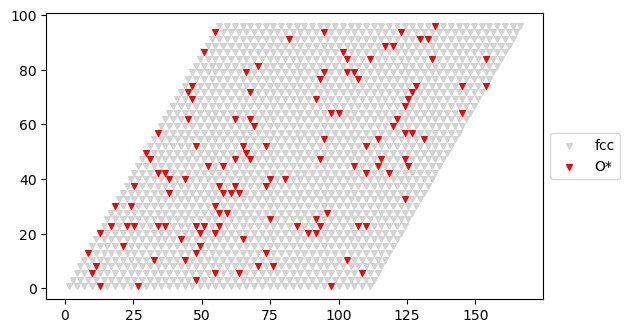

In [43]:
ads_coords,v1,v2 = zf.get_xy(Path.cwd() /"zacros_run_0080_upto0nn_0200/lattice_input.dat")
zf.lattice_plot(Path.cwd() /"zacros_run_0080_upto0nn_0200/lattice_input.dat")

In [45]:
ads_coords[0]

array([12.6951075 , 20.35978815])

In [ ]:

plot_rdf(ads_coords, v1, v2, lattice_constant=lattice_constant, r_max=40.0, dr=0.1)

In [ ]:
n_clusters = []
cluster_counts = []
lat_sizes = [f"{i}x{i}" for i in range(3, 15)]
for lat_size in lat_sizes:

    with open(run_dir / lat_size / 'energlist_output.txt', 'r') as file:
        lines = file.readlines()

    cl_names = lines[0].split()[1:]
    for i, line in enumerate(lines):
        if 'energetics_list_entry' in line: break
        
    n_clusters.append(int(lines[i+1].split()[0]))
    cluster_list = [int(line.split()[0]) for line in lines[i+2: i+2+n_clusters[-1]]]

    cluster_counts.append([cluster_list.count(i) for i in range(1, 11)])


# Extract lattice sizes as numbers (e.g., '3x3' -> 3)
x_vals = [int(size.split('x')[0]) for size in lat_sizes]

for i in range(10):

    plt.figure()
    plt.xlabel('Lattice Size (N)')
    plt.ylabel('# of Clusters / # of adsorbates')
    plt.title(f'# of {cl_names[i]} clusters')
    plt.grid(True)

    y_vals = [cluster_counts[l][i]/nsites**2 for l, nsites in enumerate(x_vals)]
    plt.plot(x_vals, y_vals,'o-')




TypeError: unsupported operand type(s) for /: 'str' and 'str'

In [ ]:
96/16

6.0